In [95]:
# TODO descriptions...

In [116]:
import os
import datetime

import tensorflow as tf
from matplotlib import pyplot as plt

from utils.image_transformation import random_jitter, normalize, resize
from utils.mnist_loader import get_mnist_data_set
from utils.model_utils import u_net_generator, discriminator, plot_transformations, UNetLayerConfiguration, \
    DownsampleLayerConfiguration, LayerConfiguration, create_training_function, get_instance_data_set_generator

In [107]:
# create directory for logs
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

In [108]:
# get samples of images with digits '1' and '7' in correct format
X_1s, X_7s = get_mnist_data_set()

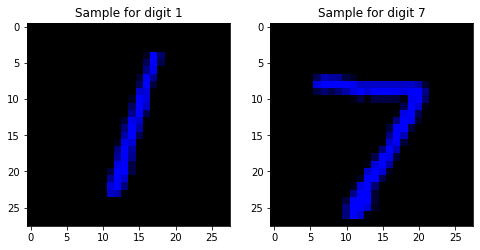

In [109]:
# show a sample per digit

plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Sample for digit 1')
plt.imshow(normalize(X_1s[0]) * 0.5 + 0.5)

plt.subplot(122)
plt.title('Sample for digit 7')
plt.imshow(normalize(X_7s[0]) * 0.5 + 0.5)

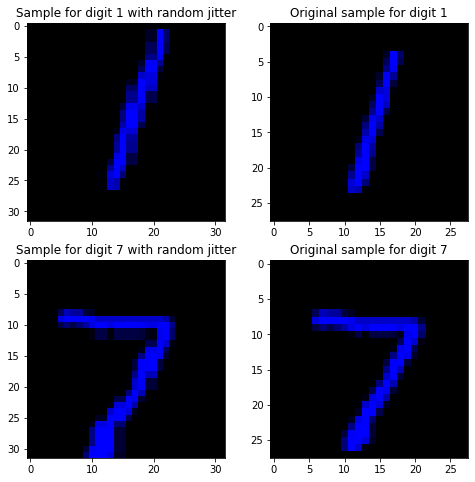

In [110]:
# show a sample per digit with applied random jitter

new_image_1 = normalize(random_jitter(X_1s[0], target_size=(32, 32), mirror=False))
new_image_7 = normalize(random_jitter(X_7s[0], target_size=(32, 32), mirror=False))

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title('Sample for digit 1 with random jitter')
plt.imshow(new_image_1 * 0.5 + 0.5)

plt.subplot(222)
plt.title('Original sample for digit 1')
plt.imshow(normalize(X_1s[0]) * 0.5 + 0.5)

plt.subplot(223)
plt.title('Sample for digit 7 with random jitter')
plt.imshow(new_image_7 * 0.5 + 0.5)

plt.subplot(224)
plt.title('Original sample for digit 7')
plt.imshow(normalize(X_7s[0]) * 0.5 + 0.5)

In [124]:
# define architecture of networks and initialize networks

# how many output channels to have
output_channels = 3

# define generator architecture
u_net_encoder_decoder_layers = tuple([UNetLayerConfiguration(16, 3, apply_norm=False), UNetLayerConfiguration(32, 3), 
                                      UNetLayerConfiguration(64, 3)])
u_net_connecting_layers = tuple([DownsampleLayerConfiguration(64, 3)])

# define discriminator architecture
discriminator_downsampling_layers = tuple([DownsampleLayerConfiguration(16, 3, apply_norm=False), 
                                           DownsampleLayerConfiguration(32, 3)])
discriminator_final_convolution_layer = LayerConfiguration(64, 3)

# initialize generators
generator_x2y = u_net_generator(output_channels=output_channels, encoder_decoder_layers=u_net_encoder_decoder_layers,
                    connecting_layers=u_net_connecting_layers, input_shape=(32, 32, 3), kernel_size_last_layer=3)
generator_y2x = u_net_generator(output_channels=output_channels, encoder_decoder_layers=u_net_encoder_decoder_layers,
                    connecting_layers=u_net_connecting_layers, input_shape=(32, 32, 3), kernel_size_last_layer=3)

# initialize discriminators
discriminator_x = discriminator(input_shape=(32, 32, 3), downsampling_layers=discriminator_downsampling_layers,
                                final_convolution_layer=discriminator_final_convolution_layer, kernel_size_last_layer=3)
discriminator_y = discriminator(input_shape=(32, 32, 3), downsampling_layers=discriminator_downsampling_layers,
                                final_convolution_layer=discriminator_final_convolution_layer, kernel_size_last_layer=3)

In [125]:
# get data set generators

# define function to apply on each data sample
function_to_apply_per_train_instance=lambda image: \
    tf.cast([normalize(random_jitter(image, target_size=(32, 32), mirror=False))], tf.float32)
function_to_apply_per_test_instance=lambda image: tf.cast([normalize(resize(image, size=(32, 32)))], tf.float32)

data_set_generator_x_train = get_instance_data_set_generator(X_1s[:200], function_to_apply_per_train_instance)
data_set_generator_x_test = get_instance_data_set_generator(X_1s[200:250], function_to_apply_per_test_instance)
data_set_generator_y_train = get_instance_data_set_generator(X_7s[:200], function_to_apply_per_train_instance)
data_set_generator_y_test = get_instance_data_set_generator(X_7s[200:250], function_to_apply_per_test_instance)

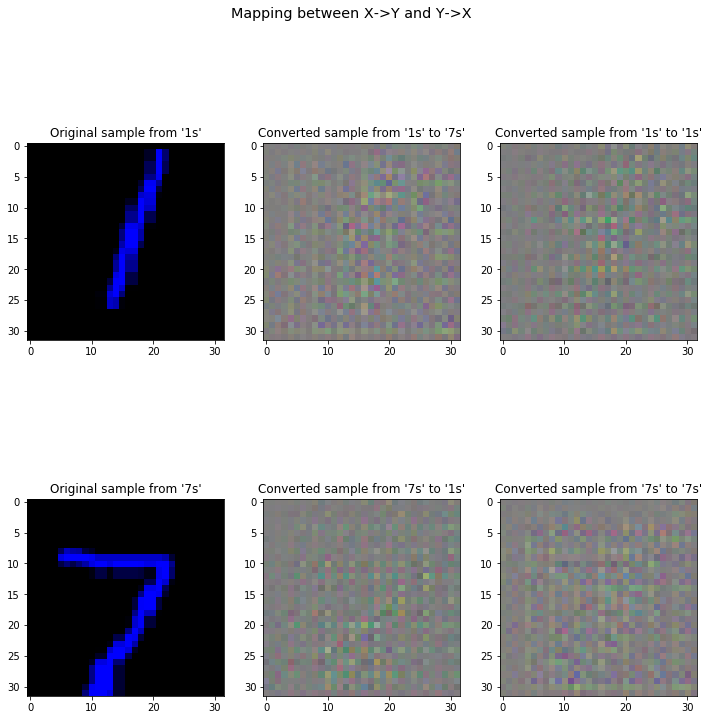

In [126]:
# plot transformations (before training)
plot_transformations(new_image_1, new_image_7, generator_x2y, generator_y2x, distributions_names=('1s', '7s'))

In [127]:
# init. summary writer
summary_writer = tf.summary.create_file_writer(logs_base_dir + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# init. training epoch executor
training_epoch_executor = create_training_function(data_set_generator_x_train, data_set_generator_y_train, 200, 
                                                   generator_x2y, discriminator_x, generator_y2x, discriminator_y, 
                                                   summary_writer=summary_writer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

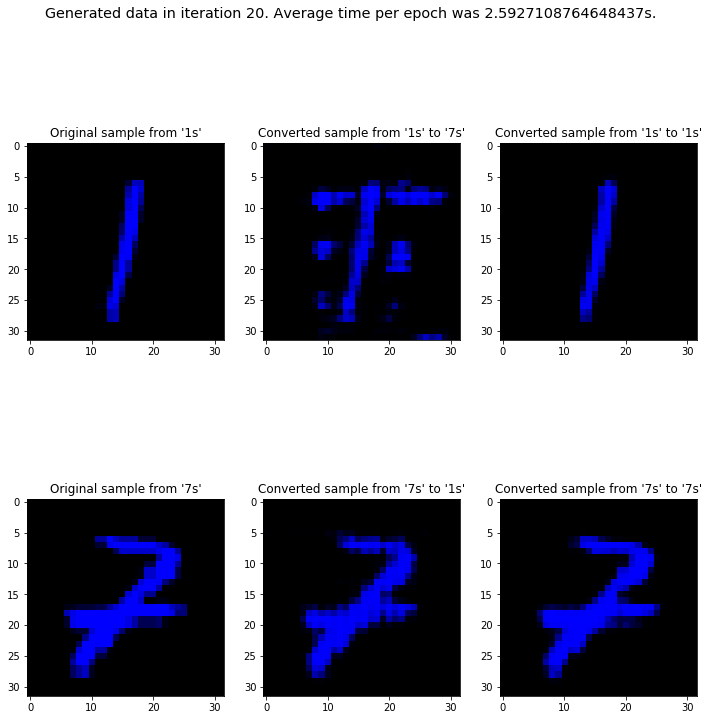

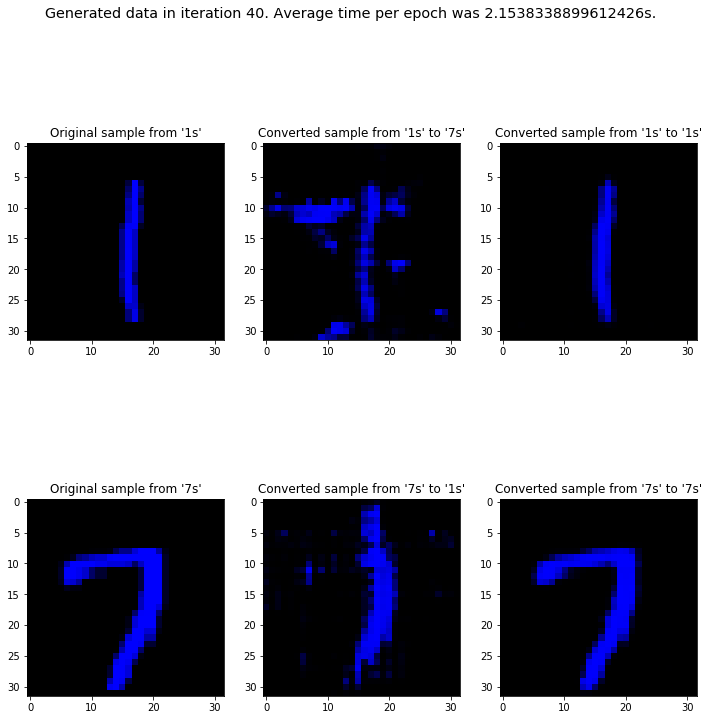

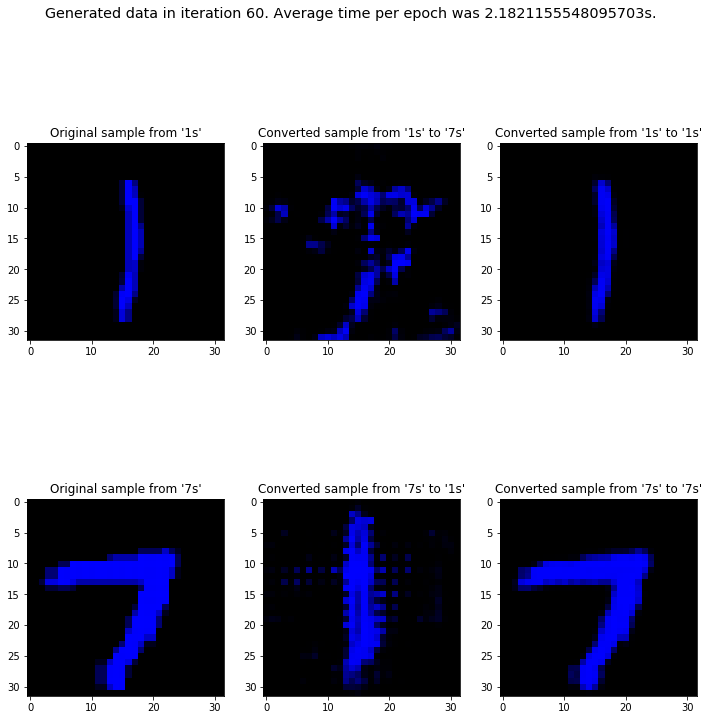

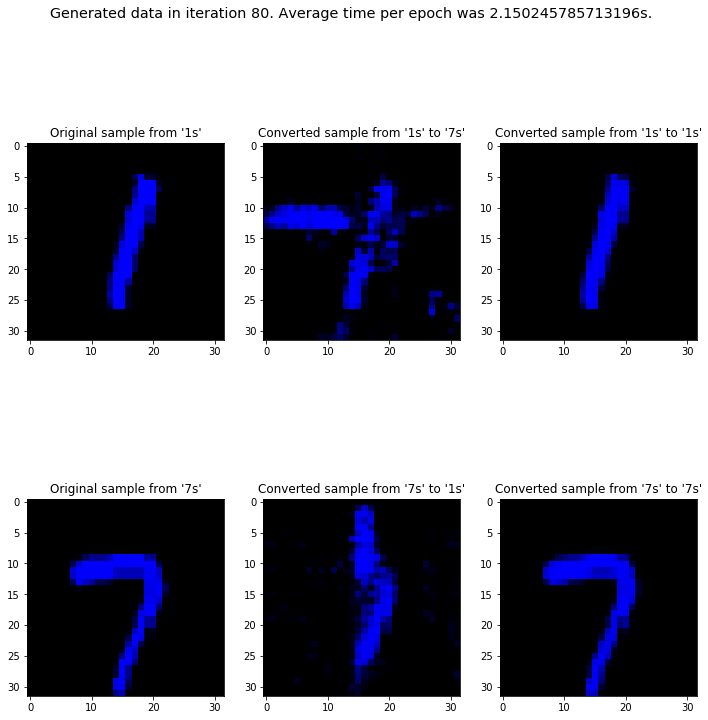

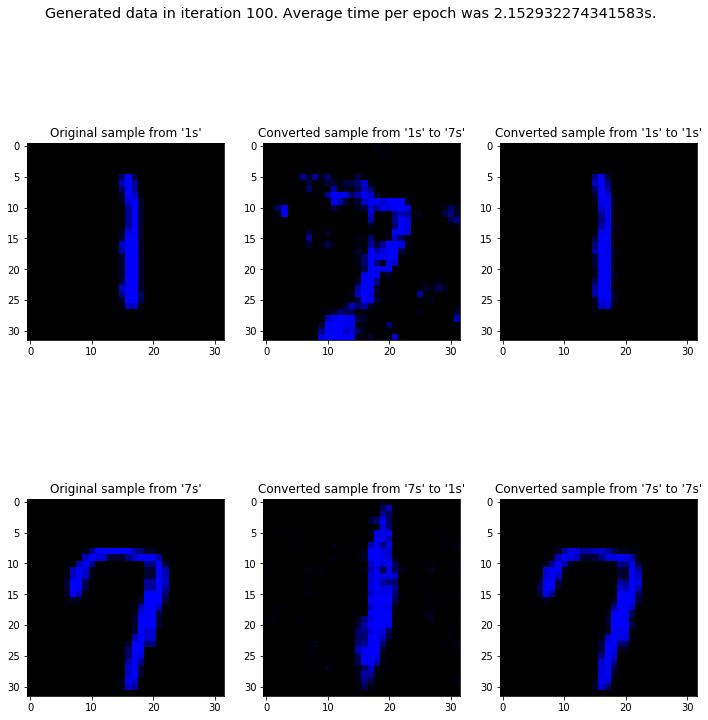

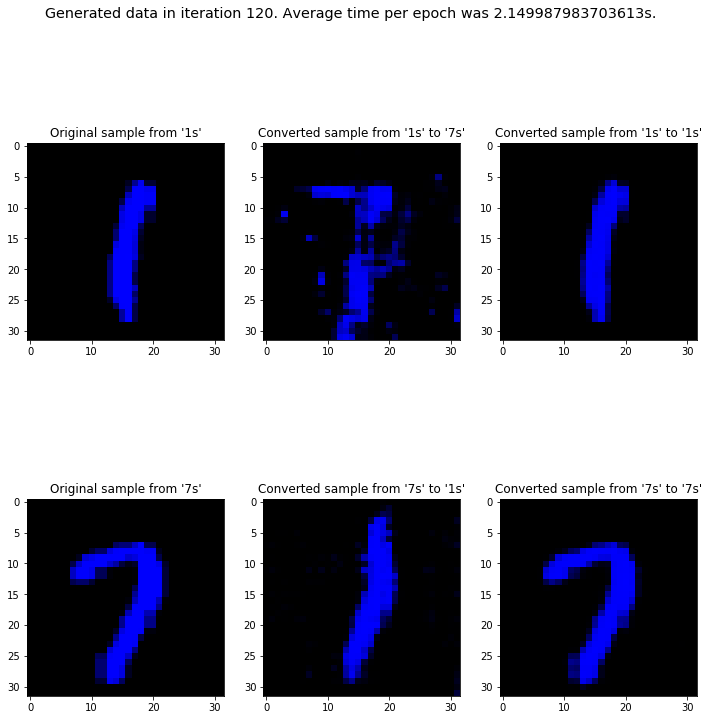

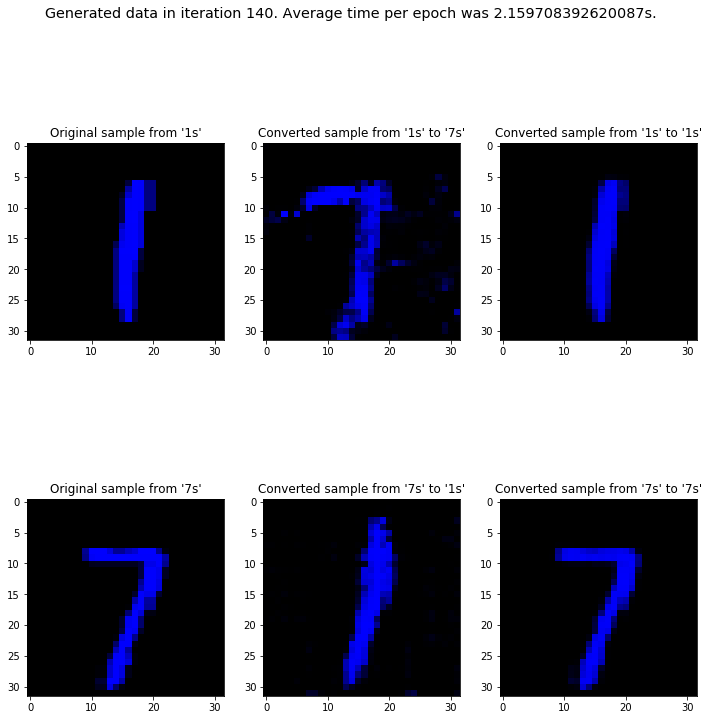

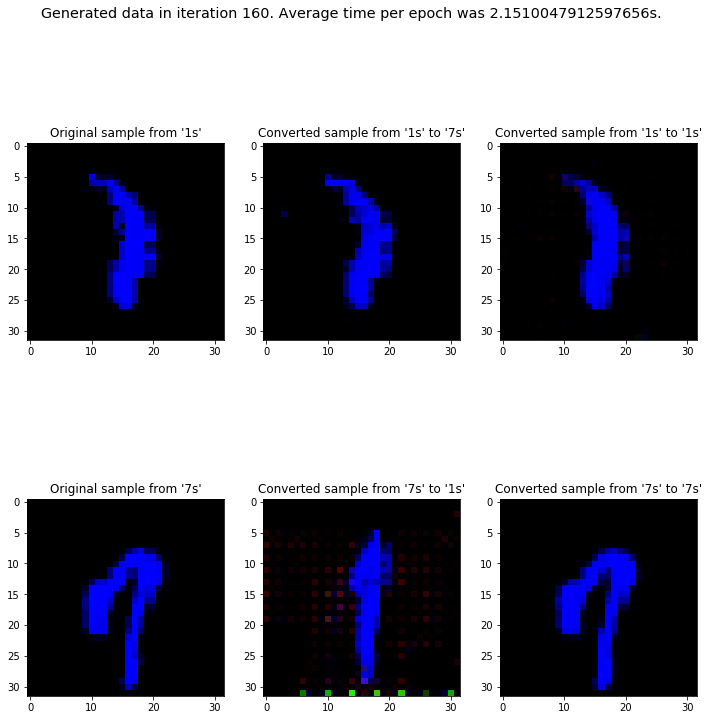

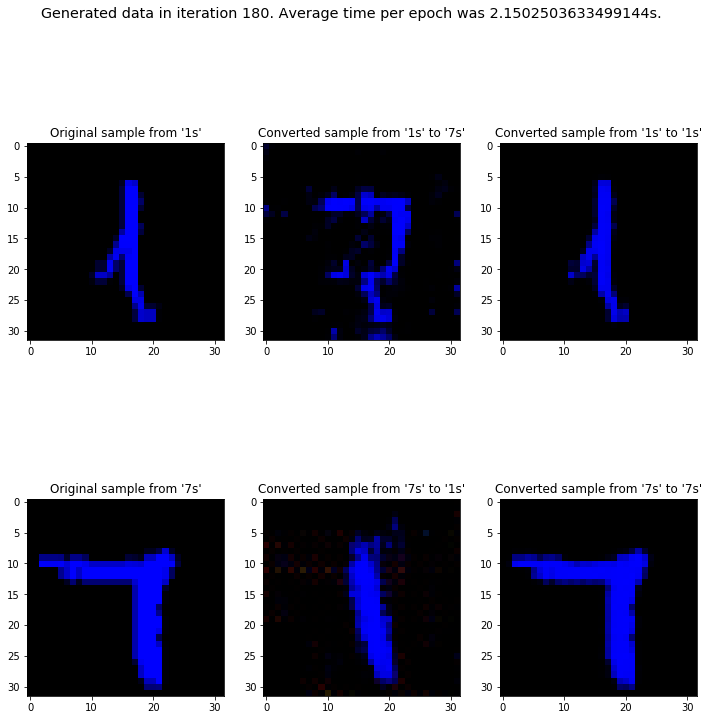

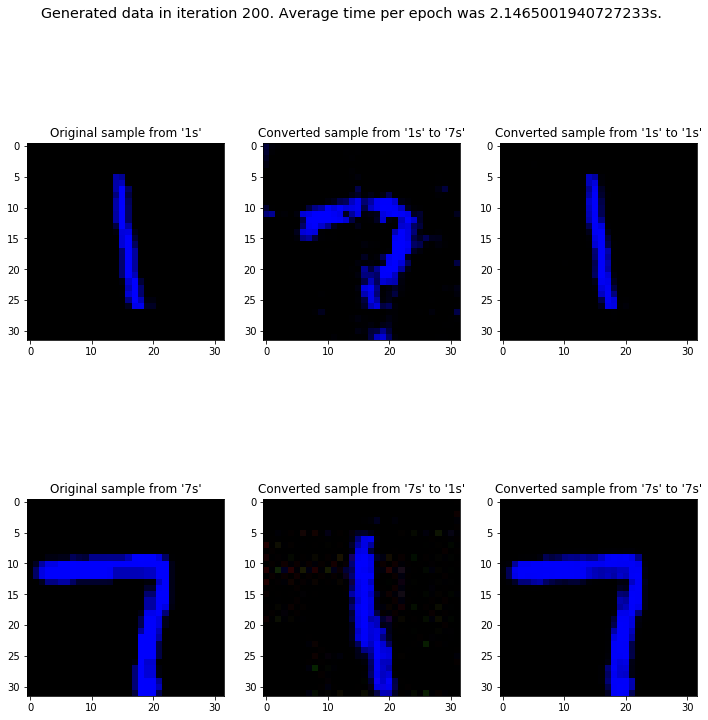

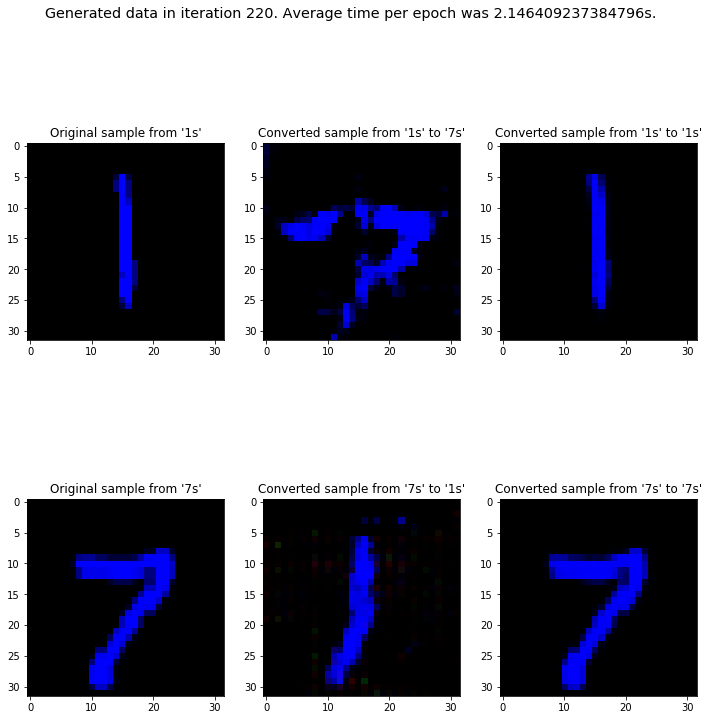

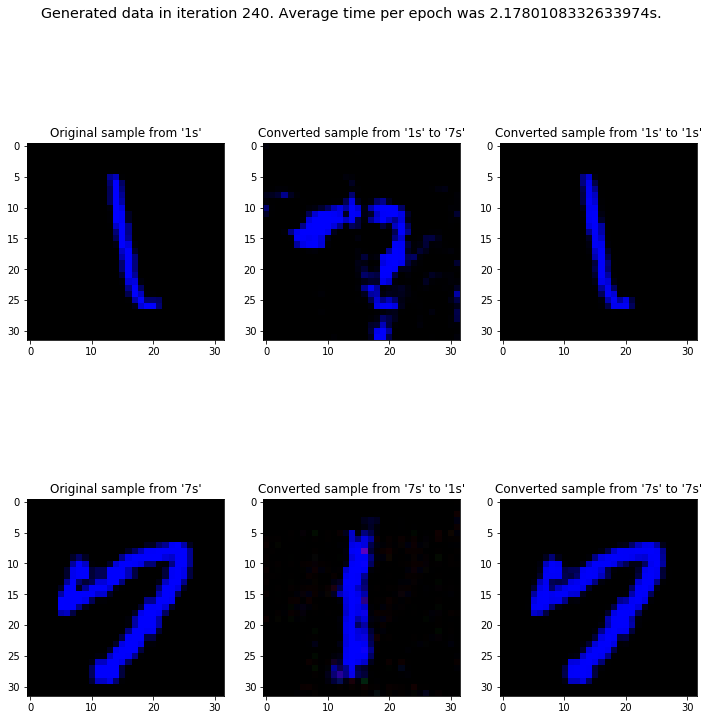

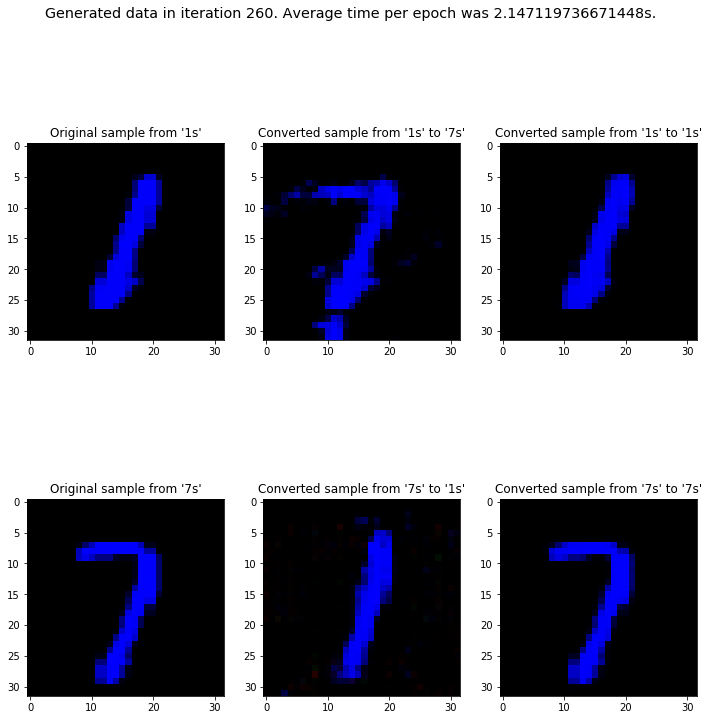

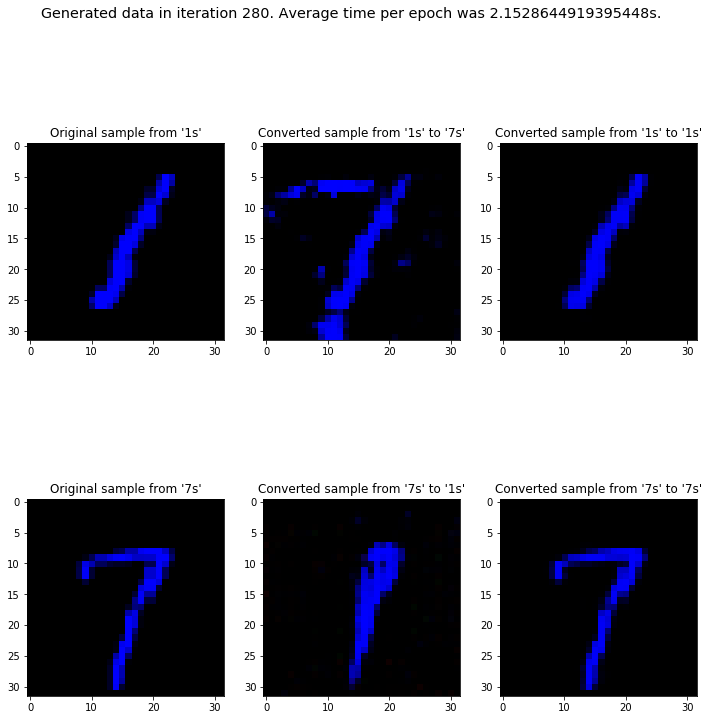

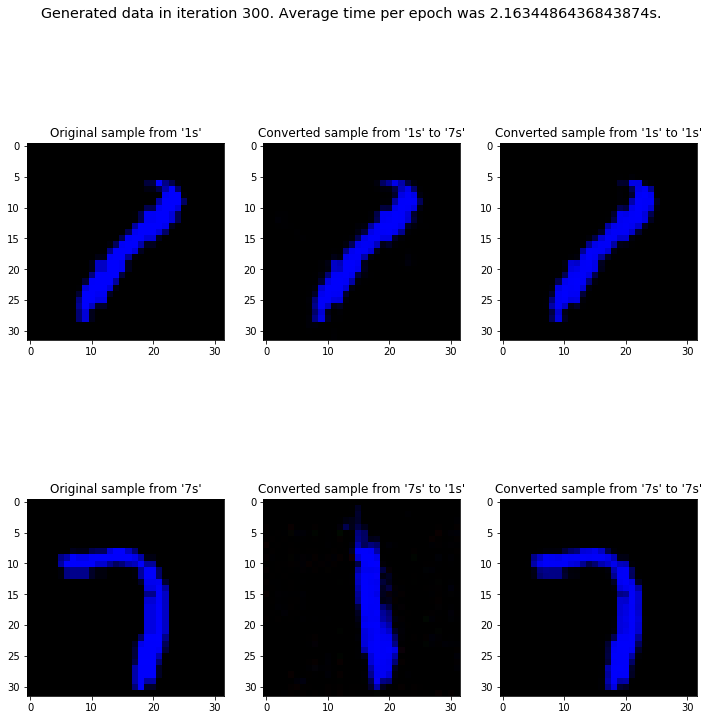

In [128]:
# run training for N number of epochs

sum_time = 0

for i in range(300):
    epoch, tm = next(training_epoch_executor)
    sum_time = sum_time + tm
    if (epoch + 1) % 20 == 0:
        # plot the most recent results
        plot_transformations(next(data_set_generator_x_test)[0], next(data_set_generator_y_test)[0], generator_x2y, 
                             generator_y2x, distributions_names=('1s', '7s'), 
                             main_title="Generated data in iteration {}. Average time per epoch was {}s."
                             .format(epoch+1, sum_time / 20))
        # reset timer
        sum_time = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


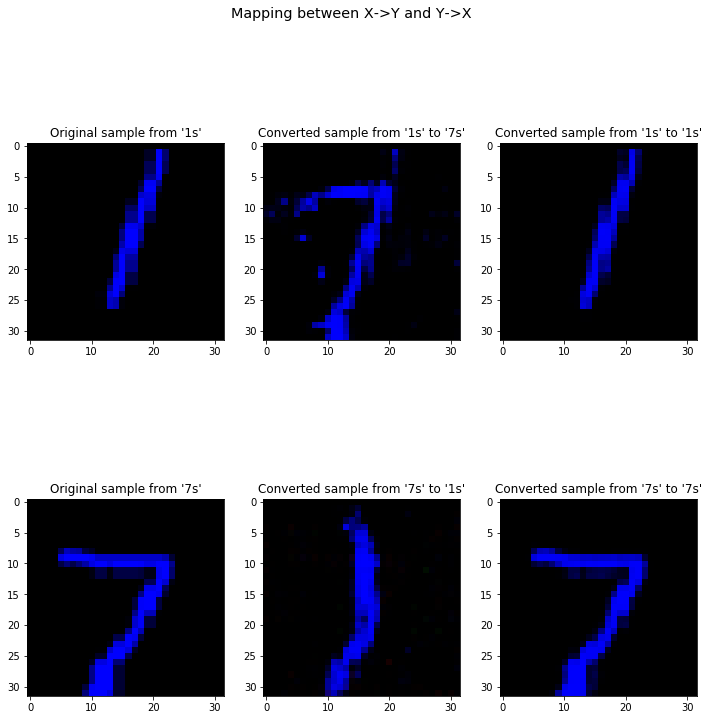

In [130]:
# plot transformations (after training)
plot_transformations(new_image_1, new_image_7, generator_x2y, generator_y2x, distributions_names=('1s', '7s'))